In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from calibration import lifetime_to_temperature_201112, pict_calibration
from scipy.optimize import curve_fit
import seaborn as sns
from PIL import Image
import scipy as sp
import cv2
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
#PATHの読み込み
intensity_path = []
lifetime_path = []
files = glob.glob('/Users/masaharu/Desktop/執筆論文/温度ダイナミクス論文/Fig4/Fig4a/150mW_1sec_50rep_cell05/150mW_1sec_50rep_2_150mW_1sec_50rep_64_2_?/')
files.sort()
for file in files:
    path = glob.glob(file + '/*ch00.tif')
    path.sort()
    intensity_path += path
    path = glob.glob(file + '/*ch01.tif')
    path.sort()    
    lifetime_path += path

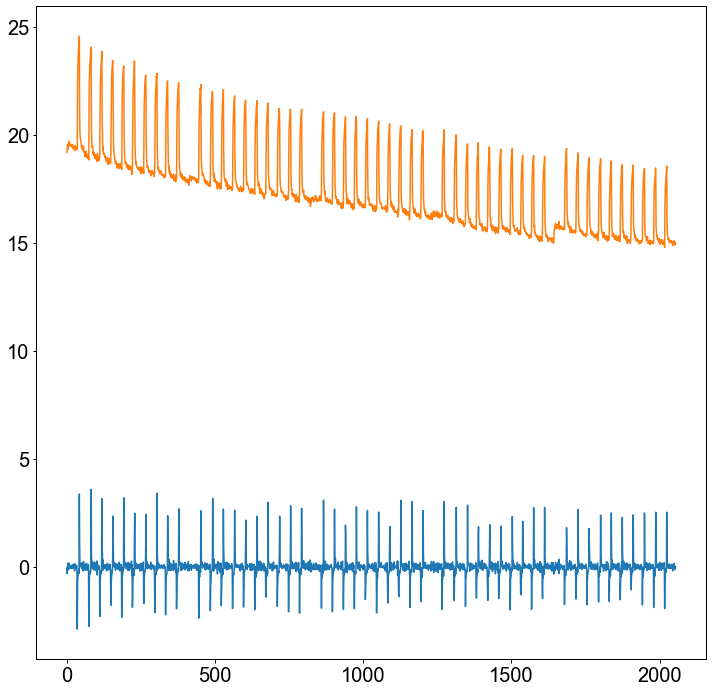

In [3]:
#IRレーザーがoffになるタイミングを探す
int_mean = []

for files in intensity_path:


    #加熱中心の強度変化
    int_image = np.array(Image.open(files))
    mean = np.mean(int_image)
    int_mean.append(mean)

diff = np.array(int_mean)[:-1] - np.array(int_mean)[1:]

#体裁調整
plt.figure(figsize = (12, 12))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams["font.size"] = 20

off_index = pd.DataFrame(diff)
off_index = np.ravel(off_index[off_index[0] > 1].index)

plt.plot(diff)
plt.plot(int_mean)
plt.show()


off_index_corrected = []
for index in off_index:
    max_index = pd.DataFrame(diff)[index - 5: index + 5][0].idxmax()
    off_index_corrected.append(max_index)
off_index_corrected = pd.DataFrame(off_index_corrected).drop_duplicates()

In [4]:
len(off_index_corrected)

50

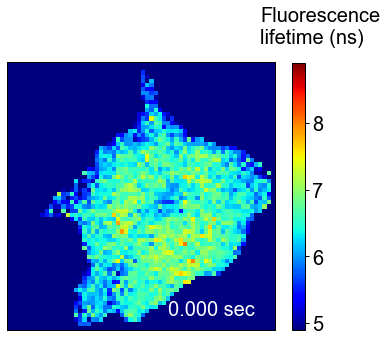

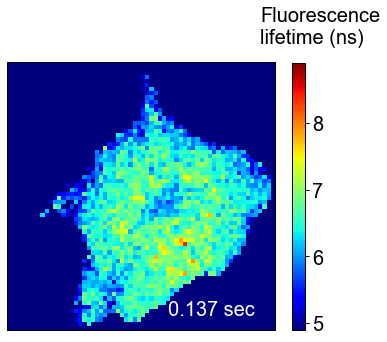

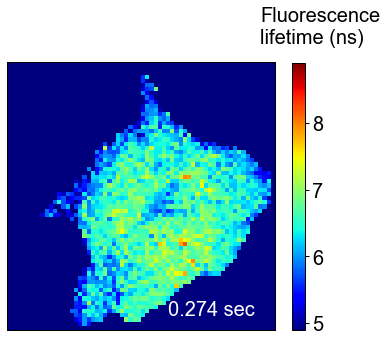

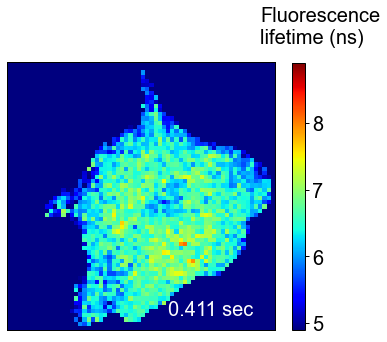

/var/folders/6w/hyvmhz8n61s0fqn11gs2dkfr0000gn/T/ipykernel_37163/1335372571.py:14: RuntimeWarning: invalid value encountered in true_divide
  lifetime_image = lifetime_image/intensity_image


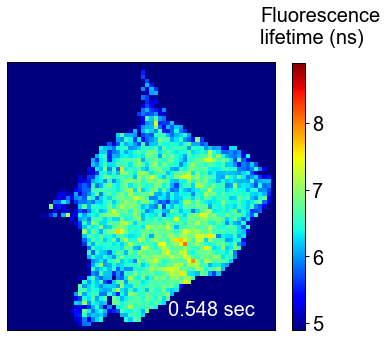

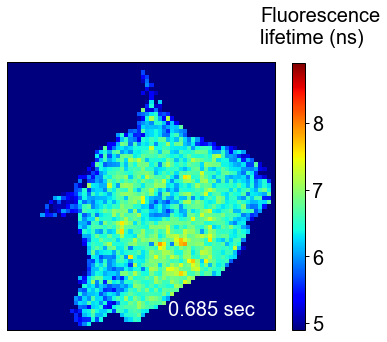

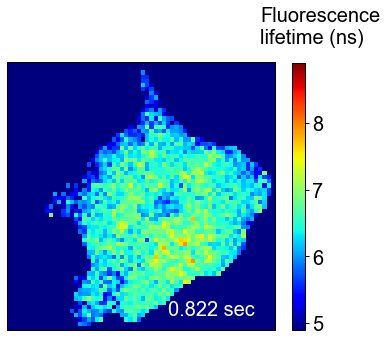

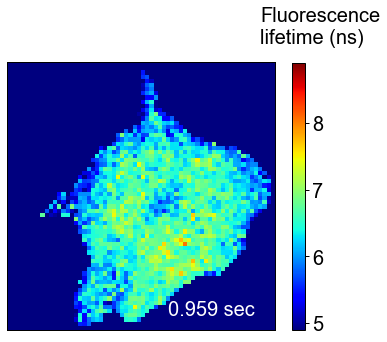

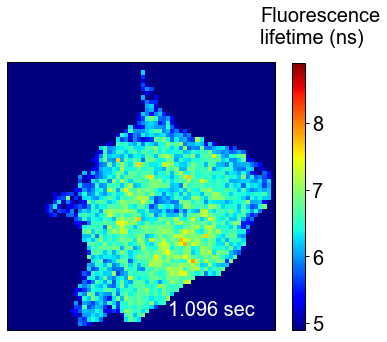

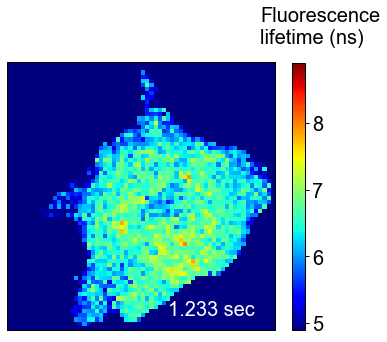

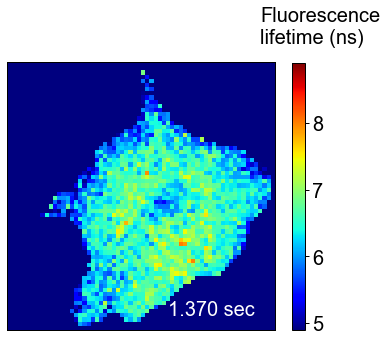

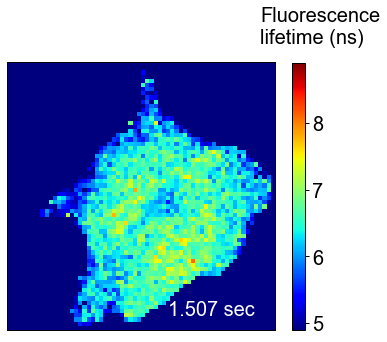

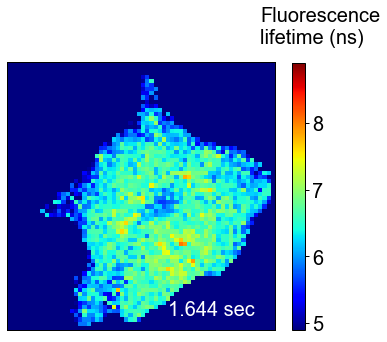

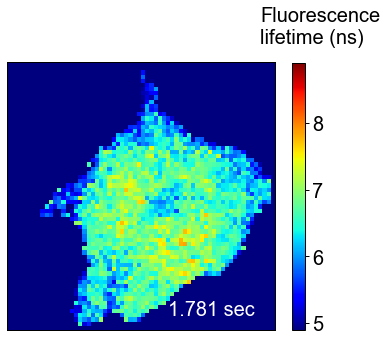

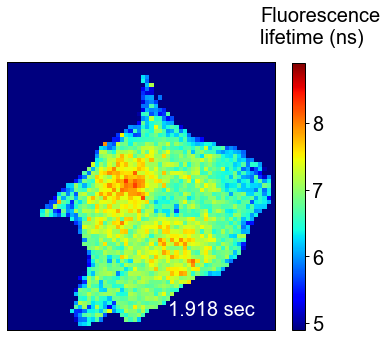

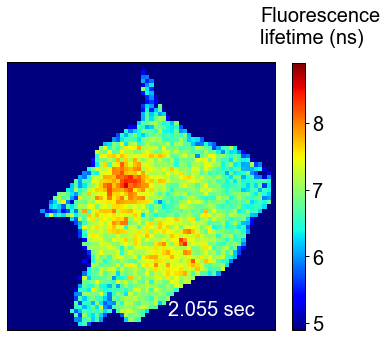

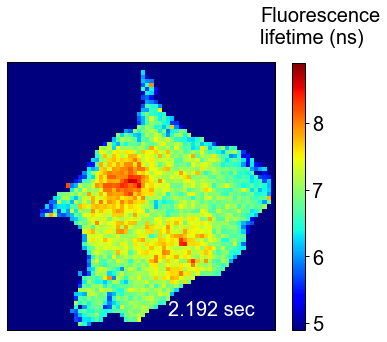

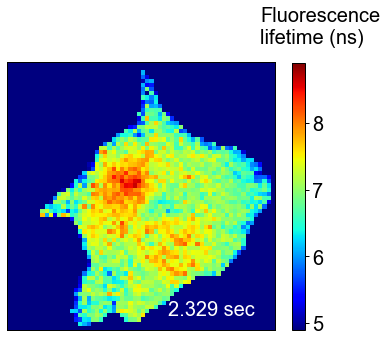

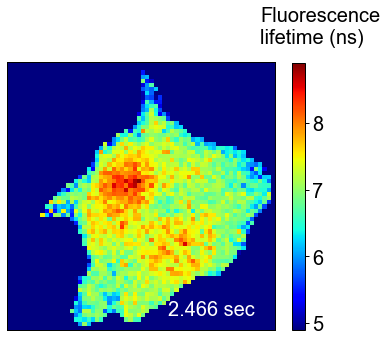

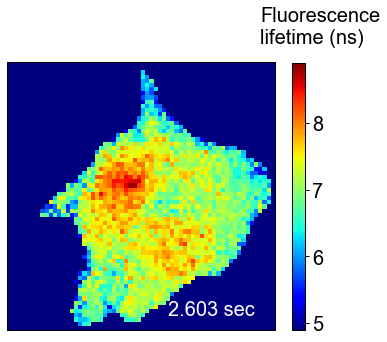

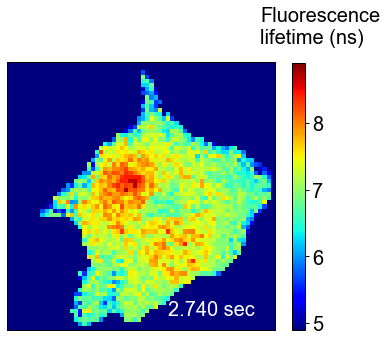

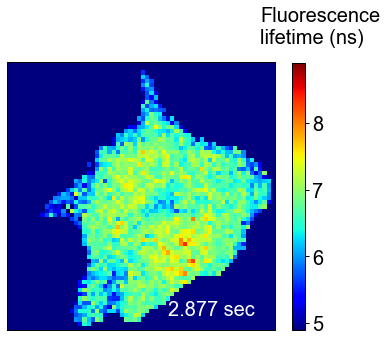

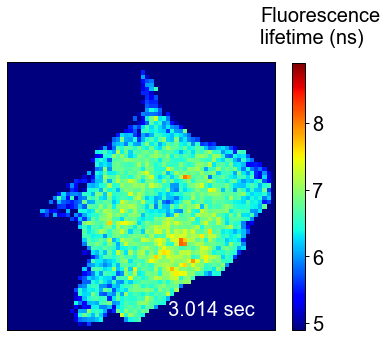

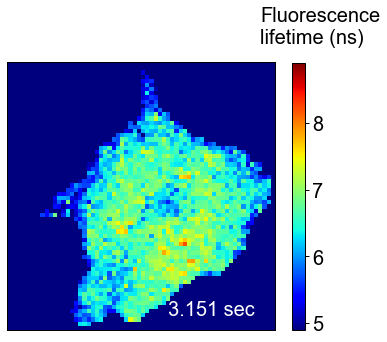

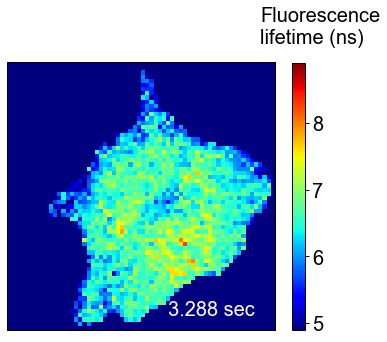

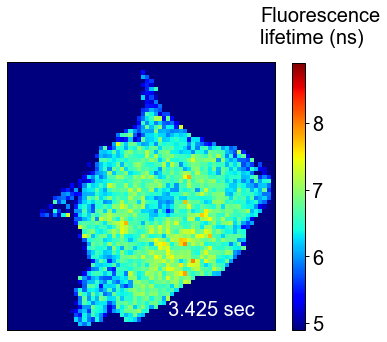

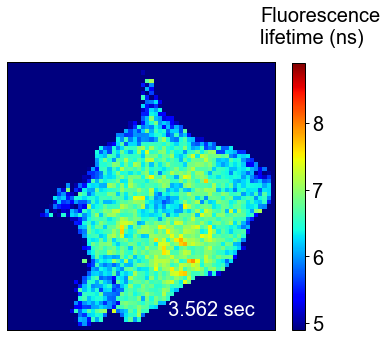

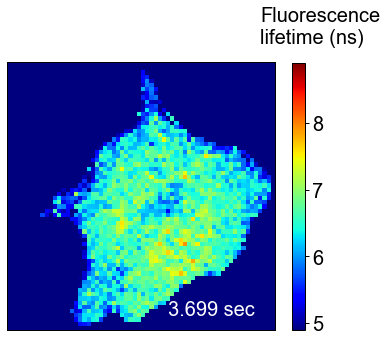

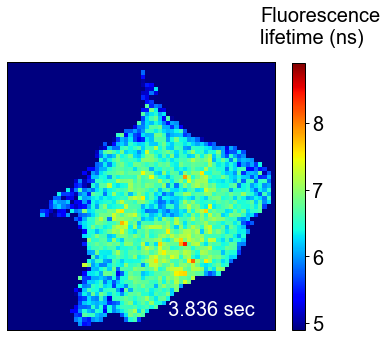

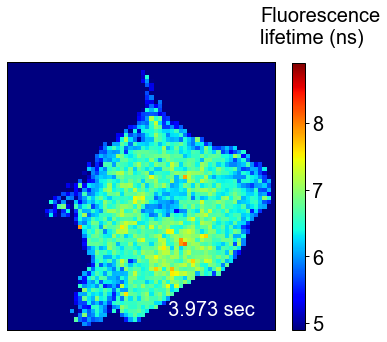

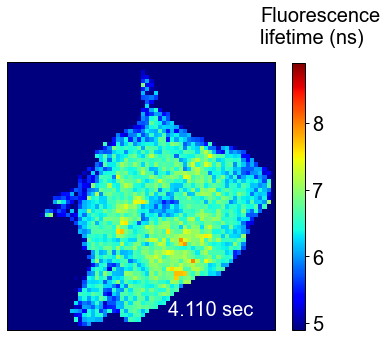

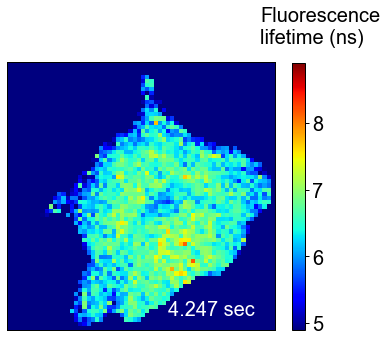

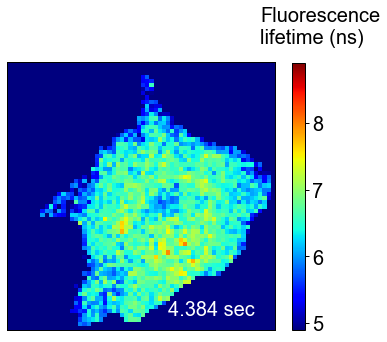

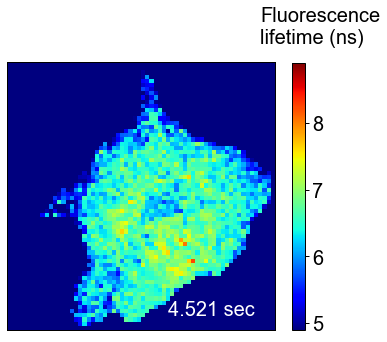

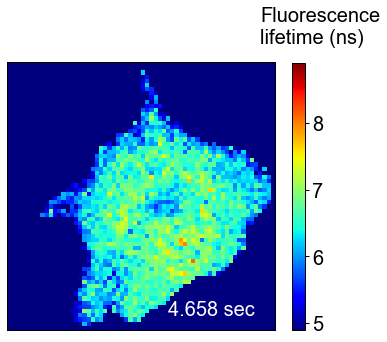

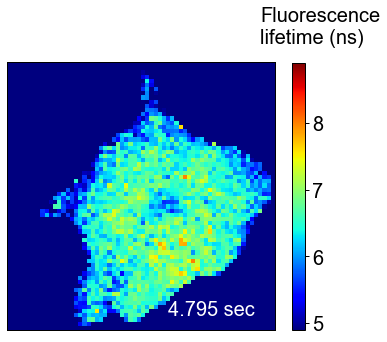

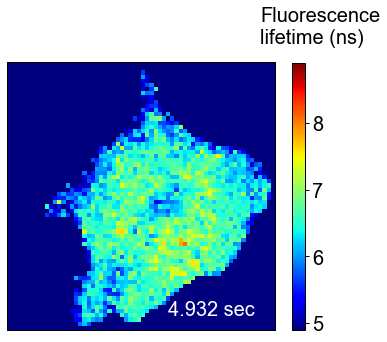

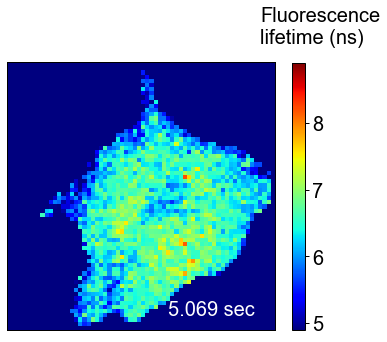

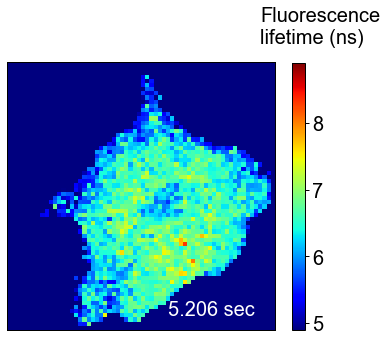

/var/folders/6w/hyvmhz8n61s0fqn11gs2dkfr0000gn/T/ipykernel_37163/1335372571.py:14: RuntimeWarning: invalid value encountered in true_divide
  lifetime_image = lifetime_image/intensity_image


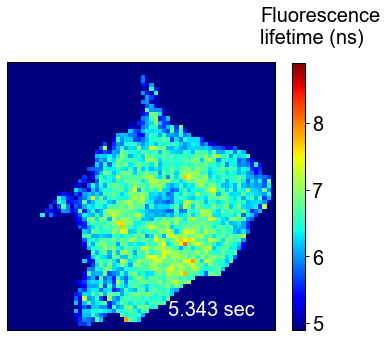

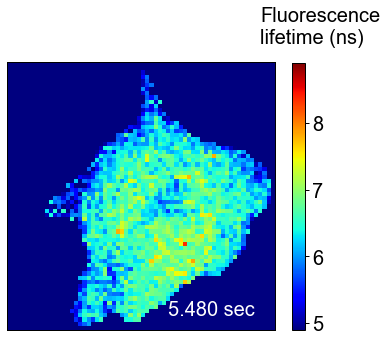

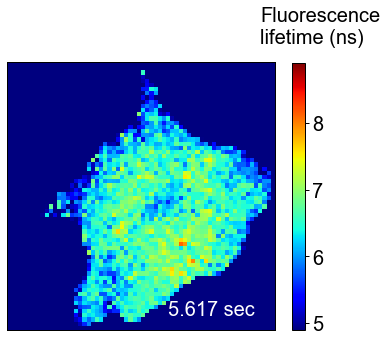

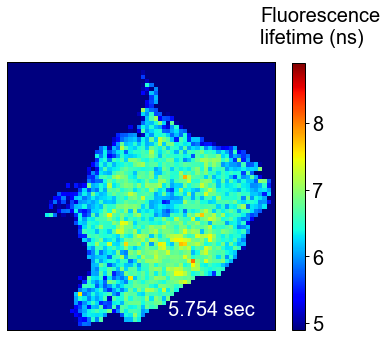

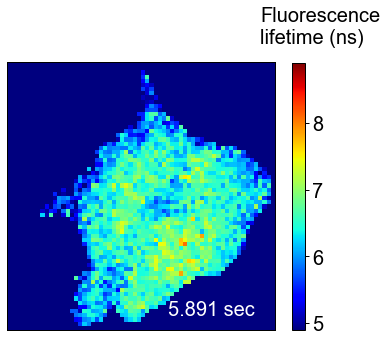

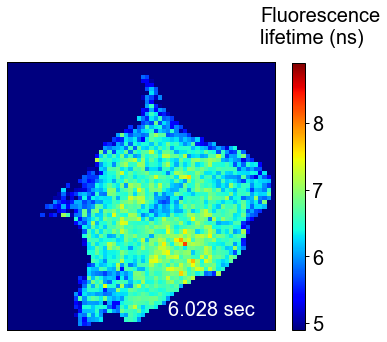

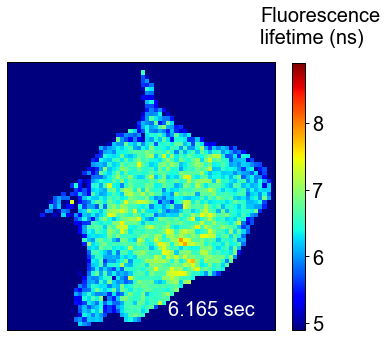

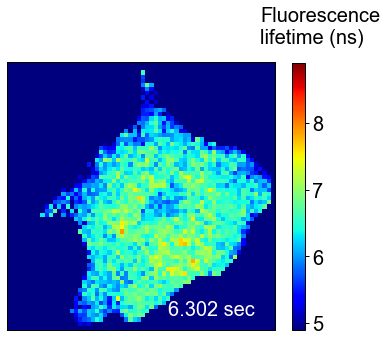

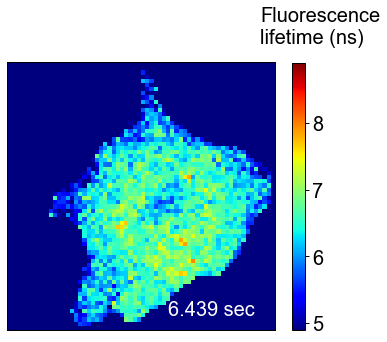

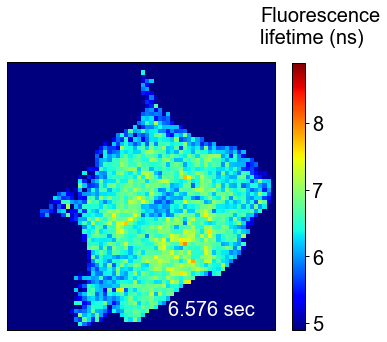

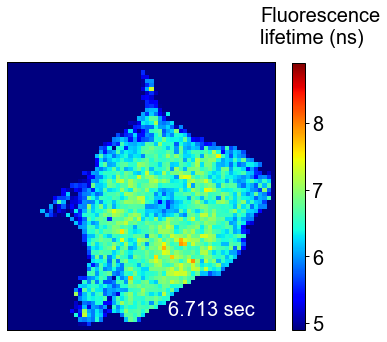

In [7]:
#細胞全体で温度の緩和を見る
frame = 1
masking = np.array(Image.open('/Users/masaharu/Desktop/執筆論文/温度ダイナミクス論文/Fig4/Fig4a/150mW_1sec_50rep_cell05/masking.tif'))
mean_lifetime = []
for fix_time in range(-20, 30):
    lifetime_image = np.zeros((64, 64))
    intensity_image = np.zeros((64, 64))
    for index in off_index_corrected[:-1][0]:
        time = index + fix_time
        path_tmp_lifetime = lifetime_path[time]
        path_tmp_intensity = intensity_path[time]
        lifetime_image += np.array(Image.open(path_tmp_intensity))*(np.array(Image.open(path_tmp_lifetime))/1000)
        intensity_image += np.array(Image.open(path_tmp_intensity))
    lifetime_image = lifetime_image/intensity_image
    lifetime_image = np.nan_to_num(lifetime_image*masking)
    mean_lifetime.append(np.mean(lifetime_image[np.where(lifetime_image > 0)]))
    
    tmp_image = lifetime_to_temperature_201112(lifetime_image)
    tmp_image[(tmp_image>50)] = 0
    tmp_image[(tmp_image<20)] = 0
    im = Image.fromarray(tmp_image)
    im.save('/Users/masaharu/Desktop/執筆論文/温度ダイナミクス論文/Fig4/Fig4a/150mW_1sec_50rep_cell05/tmp_image/' + str(frame).zfill(3) + '.tif')
 
    
    #体裁調整
    fig = plt.figure(figsize = (6, 6))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['xtick.major.width'] = 1.0
    plt.rcParams['ytick.major.width'] = 1.0
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams["font.size"] = 20
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    
    
    plt.imshow(lifetime_image, vmin = 4.9, vmax = 8.9, cmap = 'jet')
    plt.colorbar(shrink = 0.82)
    
    pp = PdfPages('/Users/masaharu/Desktop/執筆論文/温度ダイナミクス論文/Fig4/Fig4a/150mW_1sec_50rep_cell05/result/'+ str(frame).zfill(3) + '.pdf')
    pp.savefig(fig)
    pp.close()
    
    time = 0.137*(frame-1)
    plt.text(60, -5, 'Fluorescence\nlifetime (ns)', color = 'black')
    plt.text(38, 60, str('{:.3f}'.format(time)) + ' sec', color = 'white')
    plt.savefig('./Uneditied_figure/Fig4a_lifetime_jpg/'+ str(frame).zfill(3) + '.jpg')
    
    frame += 1
    plt.show()

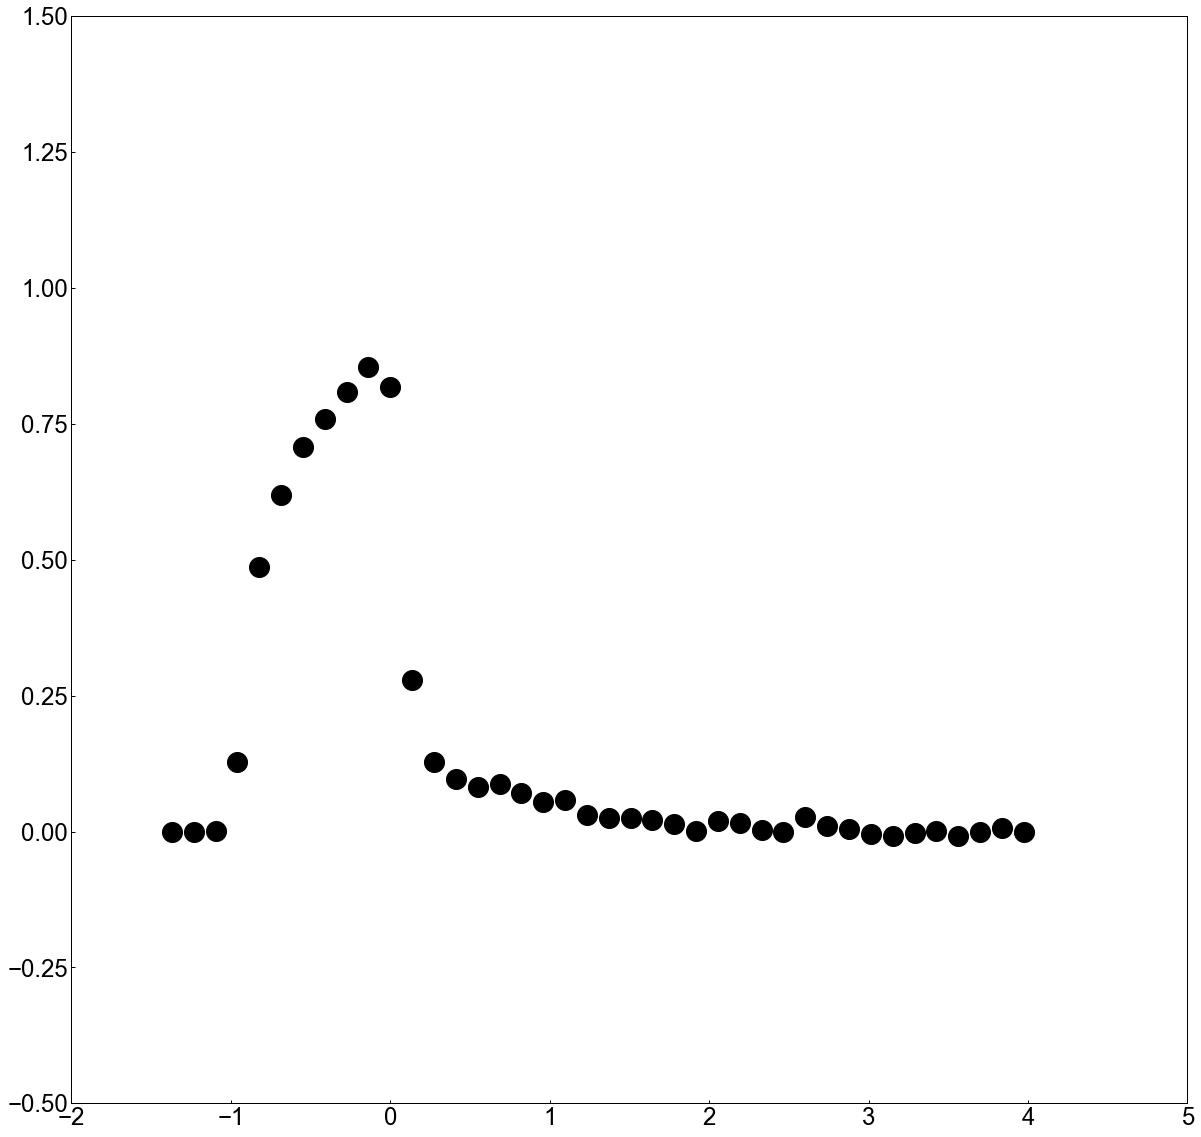

In [13]:
fig = plt.figure(figsize = (20, 20))
time = [0.137*(i-10) for i in range(len(mean_lifetime[10:]))]
mean_tmp = list(map(lifetime_to_temperature_201112, mean_lifetime[10:]))
delta_T = mean_tmp - mean_tmp[0]
plt.tick_params(axis='both', direction = "in", labelsize = 24)
plt.plot(time, delta_T, color = 'black', linewidth = 0, marker = 'o', markersize = 20)
plt.ylim(-0.5, 1.5)
plt.xlim(-2, 5)
plt.show()

#pdfのセーブ
pp = PdfPages('./Uneditied_figure/Fig4a_tmp.pdf')
pp.savefig(fig)
pp.close()

In [14]:
#動画に保存
img_array = []
for filename in sorted(glob.glob('./Uneditied_figure/Fig4a_lifetime_jpg/*.jpg')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)

name = '/Users/masaharu/Desktop/執筆論文/温度ダイナミクス論文/supplementary_video/supplementary_video2.mov'
out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'mp4v'), 1/0.137, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()